<h2 align="right">Felix Filipi</h2>
<h3 align="right">2301877590</h3>
<h1 align="center">Ujian Tengah Semester</h1>
<h1 align="center">Computer Vision

1. BeeVision is planning to build an affect-aware system that can perceive interlocutors' emotions during a social interaction through their facial expressions. Your task is to help the company build a model that can recognize emotions from facial expressions. You can use one of (or both) datasets prepared for you in https://bit.ly/COMP7116001Dataset.

a) <b>[LO 2, 20 points]</b> Build an emotion recognition model by using any machine learning techniques/algorithms of your choice. Explain comprehensively how the algorithms work and why you choose the algorithms. Moreover, explain thoroughly the features and descriptors that you implemented!

b) <b>[LO 2, 5 points]</b> Evaluate your model using evaluation metrics of your choice and explain the results!


<hr>

### The approach that will be used in this code

1. Load all images from dataset
2. Extract the descriptor of images using HoG Descriptor (explained later)
3. Fit the descriptor to SVM model
4. Train the SVM model
5. Predict the test set

<hr>

### Reason

The reason why I choose this algorithm, because this algorithm is very simple to implement, and doesn't need a lot of computational tasks. The training itself takes only a few seconds to be done (perhaps around 8-10 seconds). Since the datasets not contain a lot of samples (thousand or more), then we don't need to use CNN or other complicated deep learning techniques for this case. For the used model, I chose svm as the algorithm. The reason is SVM able to deal with a lot of dimensional feature, and work best for this case I think.

And this has been proven by the results which showing the accuracy of 100% using this method.

<hr>

### Import Libraries

In [1]:
import os
import cv2
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

### First, we need to load the dataset from directory

In [2]:
# Define root test path
root_train_path = '1/train'

# Join root path with subdirectory
first_train_path = [os.path.join(root_train_path,files) for files in os.listdir(root_train_path)]

# Init train path list
train_dataset = []

# Append each loaded images from joined directories for train set 
for each_path in first_train_path:
    all_train_path = [cv2.resize(cv2.imread(os.path.join(each_path,files),0),(128,128)) 
                      for files in os.listdir(each_path)]
    
    train_dataset.append(all_train_path)

# Define root test path
root_test_path = '1/test'

# Join root path with subdirectory
first_test_path = [os.path.join(root_test_path,files) for files in os.listdir(root_test_path)]

# Init test path list
test_dataset = []

# Append each loaded images from joined directories for test set 
for each_path in first_test_path:
    all_test_path = [cv2.resize(cv2.imread(os.path.join(each_path,files),0),(128,128)) 
                     for files in os.listdir(each_path)]
    test_dataset.append(all_test_path) 

# Define label for each train and test directory    
train_label = os.listdir(root_train_path)
test_label = os.listdir(root_test_path)

<b>To make it clear, let's try to plot 20 images of the train set from the first (sadness) class images.

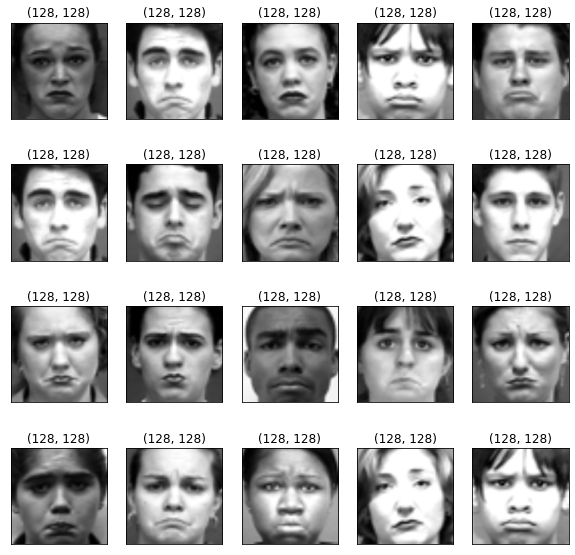

In [3]:
def visualize(image_list, title_list):
    plt.figure(figsize=(10,10))
    for i in range(20):
        plt.subplot(4,5,i+1)
        plt.title(title_list[i])
        plt.imshow(image_list[0][i], cmap='gray')
        plt.xticks([]),plt.yticks([])
        
title = [train_dataset[0][i].shape for i in range(20)]
visualize(train_dataset, title)

<b> As we can see, the image is already in the same size, also it's already grayscaled. So, we don't need to preprocess it anymore.</b>

The reason why we should resize the pixel, because the HoG descriptor have minimum winSize which is 64x64. So, to extract the descriptor we need to resize it to 128x128 .

### Now, let's extract the feature using HoG descriptor from the images

There's some reason why I choose HoG descriptor instead of SIFT and other feature extraction techniques.

SIFT descriptor works by chooses a 16x16 windows then divides it into 4x4 windows. Over each of these 4 windows it computes a Histogram of Oriented gradients (HoG). While computing this histogram, it also performs an interpolation between neighboring angles. Once we have all the 4x4 windows, it will use a gaussian of half the window size, centered at the center of the 16x16 block to weight the values in the whole 16x16 descriptor. Meanwhile, HoG on the other hand only computes a simple histogram of oriented gradients as the name says.

<b>And this is the reason why SIFT algorithm is more suited in describing the importance of a point</b>, due to the gaussian weighting involved, <b>while HoG does not have such a bias.</b> Due to this reason, <u>HoG should be better suited at classification of images over dense SIFT</u>, if all feature vectors are concatenated into one huge vector
And this is the reason why I choose HoG as its descriptor.

In [4]:
# initialize result list
descriptor_result = []

for each_class in range(len(train_dataset)):
    
    # Initialize list for each class from image
    each_class_desc = []
    
    for each_images in range(len(train_dataset[each_class])):
        
        # Extract the descriptor using HoG algorithm 
        descriptor = cv2.HOGDescriptor()
        desc = descriptor.compute(train_dataset[each_class][each_images])
        each_class_desc.append(desc)
        
    descriptor_result.append(each_class_desc)

### Now, we need to modify the input to be able processed in the model.

Before: The train label just contain the class name of the dataset

After: Now, we need to create class label for each of the images, not only for the dataset. Later on, we need to reshape the input set.

In [5]:
# initialize result label
concat_train_label = []

# For each class create array with size of train set with value of train label
for i in range(len(train_dataset)):
    label = np.full((len(train_dataset[i]),1), train_label[i])
    concat_train_label.append(label)

# Reshape the train_label become 1D array    
train_label = np.concatenate(concat_train_label).reshape(-1)

# Reshape the train_set become 2D array
train_set = np.concatenate(descriptor_result)

just to give an approximate idea of the intended result.

In [6]:
print(f'Train Label shape = {train_label.shape}')
print(f'Train Set shape = {train_set.shape}')
print(f'Train_label example: {train_label[:5]}')
print(f'Train_set example: {train_set[:5]}')

Train Label shape = (981,)
Train Set shape = (981, 34020)
Train_label example: ['sadness' 'sadness' 'sadness' 'sadness' 'sadness']
Train_set example: [[0.36245027 0.16735618 0.02832391 ... 0.39319718 0.01569067 0.01869876]
 [0.33394456 0.2977556  0.12241053 ... 0.22139965 0.02996742 0.2012919 ]
 [0.3436371  0.3436371  0.3436371  ... 0.19559102 0.17856222 0.15723991]
 [0.29242915 0.20534334 0.08842483 ... 0.2730302  0.12201176 0.05361739]
 [0.10426263 0.09122252 0.15972437 ... 0.00621524 0.00202758 0.07711513]]


### As we can see here, the label has the same shape with the train set. Now, let's fit it to the model</b>

In [7]:
# Call SVM
clf = LinearSVC()
clf.fit(train_set, train_label)

LinearSVC()

### We've done creating the model, now let's try to predict the result

But before we process the test set, there's a thing that we should care about. The test set contain empty folder, which is fear. To overcome this, we need to remove this label and empty value from the test set

In [8]:
print(test_dataset[0])
print(test_label[0])

[]
fear


<b> Remove the empty value (first list) from test set and label to remove redundant value

In [9]:
del test_dataset[0]
del test_label[0]

<b>Compute the Descriptor for testing set</b>

This can be done by the method used in training above

In [10]:
# initialize result list
descriptor_result = []

for each_class in range(len(test_dataset)):
    
    # Initialize list for each class from image
    each_class_desc = []
    
    for each_images in range(len(test_dataset[each_class])):
        
        # Extract the descriptor using HoG algorithm 
        descriptor = cv2.HOGDescriptor()
        desc = descriptor.compute(test_dataset[each_class][each_images])
        each_class_desc.append(desc)
        
    descriptor_result.append(each_class_desc)

<b>Modify the label of the test set as the previous one 

In [11]:
# initialize result label
concat_test_label = []

# For each class create array with size of train set with value of train label
for i in range(len(test_dataset)):
    label = np.full((len(test_dataset[i]),1), test_label[i])
    concat_test_label.append(label)
    
test_label = np.concatenate(concat_test_label).reshape(-1)
test_set = np.concatenate(descriptor_result)

### Predict the emotion

In [12]:
prediction = clf.predict(test_set)

### Evaluate the model using evaluation metrics of your choice and explain the results

In [13]:
print(classification_report(test_label,prediction))

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        49
    contempt       1.00      1.00      1.00        12
     disgust       1.00      1.00      1.00        57
       happy       1.00      1.00      1.00        85
     sadness       1.00      1.00      1.00        35
    surprise       1.00      1.00      1.00       146

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



### Explanation

The result give a great result, by return 100% of accuracy. Furthermore, the training itself only take a few second (about 7 to 10 seconds perhaps), because the dataset didn't contain so much (thousand) data. And this proves that the approach used in this section (and the reason mentioned above) is best for this case.

<b> To prove that the model able to perfectly predict the test set, let's plot 20 picture and its prediction

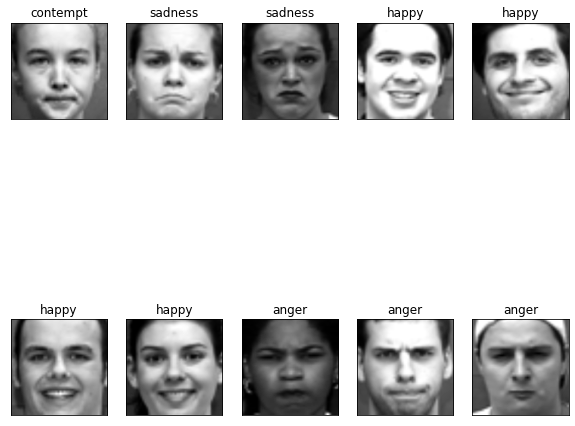

In [14]:
plot_for_test_dataset = np.concatenate(test_dataset)

j = 0
plt.figure(figsize=(10,10))
for i in range(0,200,20):
    j = j+1
    plt.subplot(2,5,j)
    plt.imshow(plot_for_test_dataset[i], cmap='gray')
    plt.title(prediction[i])
    plt.xticks([]),plt.yticks([])

### We need to use the model for the next instruction, so it will be better if we save the model using following codes

In [15]:
filename = 'model1.sav'
pickle.dump(clf, open(filename, 'wb'))

<hr>

2. Recognize the person's emotions in the picture provided in https://bit.ly/COMP7116001Dataset2 by using the model you have trained and evaluated in no 1.

a) <b>[LO 3, 10 points]</b> Detect the face within the image using the Viola-Jones algorithm and crop the face. Explain comprehensively how the algorithms work!

b) <b>[LO 1, 10 points]</b> Prepare the images (cropped face) using any image processing techniques that you think is necessary to improve the quality of the images! Explain your choice. Moreover, describe the computational principles of the image processing techniques applied in your case

c) <b>[LO 3, 5 points]</b> Recognize the emotions from the face using the model you have trained in no 1 and explain the results comprehensively!

<hr>

### Load Dataset

In [16]:
dataset_2 = [cv2.imread(os.path.join('EmotionsInWild',files)) for files in os.listdir('EmotionsInWild')]

## Detect the face within the image using the Viola-Jones algorithm and crop the face. Explain comprehensively how the algorithms work!

<hr>

The Viola-Jones algorithm also called "Haar cascade" will look at many smaller subregions and try to find a face by looking for specific features in each subregion. It will check many different positions and scales because image can contain many faces of various sizes. Viola and Jones uses Haar-like features to detect faces in this algorithm.

### The Viola-Jones algorithm has 4 main steps, which are:

<hr>

<b> 1. Selecting Haar-like features</b>

Haar-like features are digital image features used in object recognition. Human faces have some universal properties of the human face such as eyes region which is darker than its neighbour pixels, also the nose region which is brighter than the eye region, and etc.
    
There's a simple way to find which region is lighter or darker which is by sum up the pixel values of both regions and compare them. The sum of pixel values in the darker region will be smaller than the sum of pixels in the lighter region. If one side is lighter than the other, it may be an edge. Perhaps an eyebrow or the middle portion may be shinier than the surrounding boxes, which can be interpreted as a nose. This can be accomplished using Haar-like features and with the help of them, we can interpret the different parts of a face. 

There are 3 types of Haar-like features that Viola and Jones identified in their research:

- Edge features
- Line-features
- Four-sided features

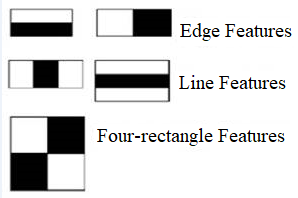

Edge features and Line features are useful for detecting edges and lines. Meanwhile, the four-sided features are used for finding diagonal features.

This Viola-Jones algorithm work like this:

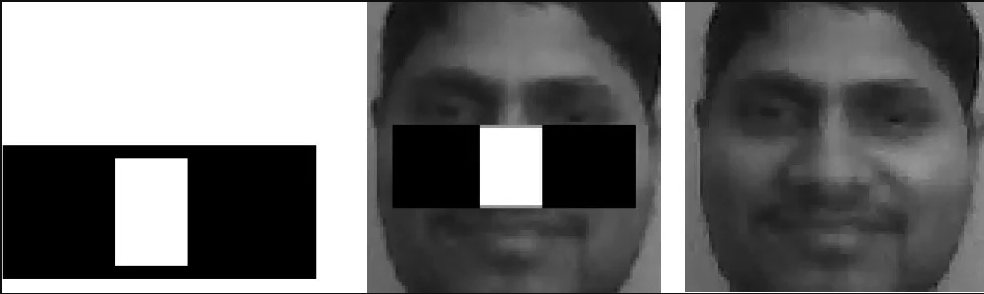

<hr>

<b>2. Creating an integral image</b>

Integral image (a.k.a summed-area table) is the name of a data structure and an algorithm which will be used used to obtain this data structure. It is used as a quick and efficient way to calculate the sum of pixel values in an image or rectangular part of an image.

In an integral image, the value of each point is the sum of all pixels above and to the left, including the target pixel:

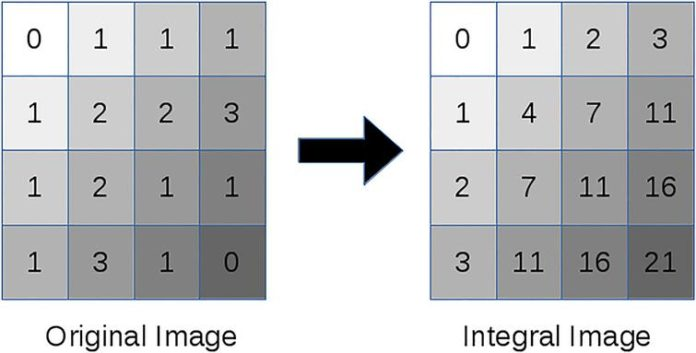

Using these integral images, we save a lot of time calculating the summation of all the pixels in a rectangle as we only have to perform calculations on four edges of the rectangle.

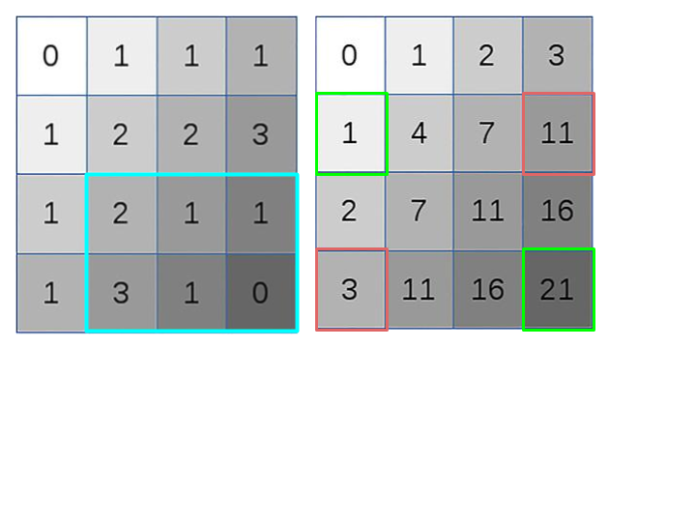

<b>3. Running AdaBoost training</b>

In the Viola-Jones algorithm, each Haar-like feature represents a weak learner. To decide the type and size of a feature that goes into the final classifier, AdaBoost checks the performance of all classifiers that supplied into it.

To calculate the performance of classifier, we need to evaluate it on all subregions of all the images used for training. Some subregions will produce a strong response in the classifier, and this will be classified as positives images which mean the classifier predict it as a human face. Meanwhile, the subregion which don’t provide a strong response called as negative or don’t contain a human face.

The classifiers that performed well are given higher importance or weight. The final result is a strong classifier, also called a boosted classifier, that contains the best performing weak classifiers

<b>4. Creating classifier cascades</b>

The job of the cascade is to quickly discard non-faces, and avoid wasting precious time and computations. Thus, achieving the speed necessary for real-time face detection.

<hr>

### And that's how the viola-jones algorithm works, now let's try to implement it to our case

In [17]:
# Call the viola-jones classifier
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")

# init empty result list
result_img = []

# for each image in dataset
for image in dataset_2:
    
    # Detect face in each image
    faces = faceCascade.detectMultiScale(image, 
                                         scaleFactor= 1.15,
                                         minNeighbors=5)
    
    # For every x point, y point, width, height in face
    for (x, y, w, h) in faces:
        
        # Crop the image
        cropped_image = image[y:y+h,x:x+w]
        
        # Append to initialized list
        result_img.append(cropped_image)

<b> Now, let's plot the cropped image, to make sure that the face recognition able to detect face

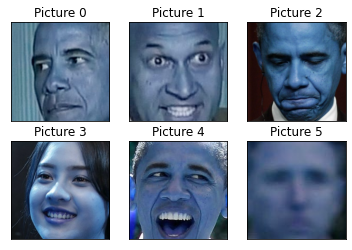

In [18]:
for i in range(len(result_img)):
    plt.subplot(2,3,i+1)
    plt.imshow(result_img[i])
    plt.title(f"Picture {i}")
    plt.xticks([]),plt.yticks([])

## As we can see here, the face has already detected and cropped, now we need to process it to improve the quality of the images

### Some techniques which will be used to preprocess the images

<hr>

<b>1. Grayscaling</b>

Grayscaling is a must in viola-jones algorithm, because viola jones work with haar features, means that we need to remove noise by using grayscale technique.

To achive grayscale, we need to compute the image using this formula:

<h3 align=center>$Gray = 0.2989 \times R + 0.5870*G + 0.1140 * B$</h3>

So, each channel in RGB of the images need to be multiplied by above formula


<b>2. Resize images / Scaling (Image Transformation)</b>

As the name itself, scaling is performing resize on an image. OpenCV comes with a function ```cv2.resize()``` for this purpose. The size of the image can be specified manually, or you can specify the scaling factor.

According to the OpenCV documentation, in dsize / output image size; if it equals zero, it is computed as:

<h3 align="center">$dsize = Size(round(f_{x} ∗ src.cols),round(f_{y}∗src.rows))$</h3>


<b>3. Sharpening (since picture 5 is blurry images)</b>

As we can see from the picture above mentioning that the last picture is so blurry, we need to preprocess it using sharpening kernel. To achieve this, we need to do sliding windows using sharpening kernel, such as I mentioned below. And here's the sharpening kernel looks like.

<h3 align="center">$Sharpening Kernel = \begin{equation}
\begin{bmatrix}
{{-1}}&-1&-1 \\
-1 & 9 & -1 \\
-1 & -1 & -1
\end{bmatrix}
\end{equation}
$</h3>

<b>4. Normalize Image </b>

Normalization means repeating data repetition and eliminate unwanted characteristics. So, Image normalization means about how we change an image’s pixel intensity. It is linked with increasing contrast, which helps in better image segmentation. 

The functions normalize scale and shift the input array elements so that



(where p=Inf, 1 or 2) when normType=NORM_INF, NORM_L1, or NORM_L2, respectively; or so that



<hr>

### And that's how the selected image processing technique works, now let's try to implement it to our case

<hr>

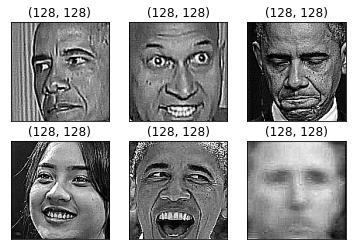

In [19]:
# initialize the empty list result
clean_result = []

# define sharpening kernel
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

# for each image
for img in result_img:
    
    # Change to grayscale
    grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize to the shape 128, 128 because the model need 128x128 input
    resize = cv2.resize(grayscaled, (128,128))
    
    # Convolve the sharpen kernel
    sharpen = cv2.filter2D(resize, -1, sharpen_kernel)
    
    # Normalize the images
    norm_img = np.zeros((sharpen.shape[0], sharpen.shape[1]))
    normalize = cv2.normalize(sharpen, norm_img, 0, 255, cv2.NORM_MINMAX)
    
    # Append to the list
    clean_result.append(normalize)
    
# Visualize the result
for i in range(len(clean_result)):
    plt.subplot(2,3,i+1)
    plt.imshow(clean_result[i], cmap="gray")
    plt.title(f"{clean_result[i].shape}")
    plt.xticks([]),plt.yticks([])

<b> As we can see here, after processing the image, we have a much far better clean images rather than before</b>

## Now, after the image processing already done, we need to predict it with our previous emotion recognizer model

<b> Load the model

In [20]:
cls = pickle.load(open('model1.sav', 'rb'))

<b> Find descriptor for the new test set as feature for our model

In [21]:
# init empty result list
desc_res = []

# for each image
for each_img in clean_result:
    
    # Find the descriptor
    descriptor = cv2.HOGDescriptor()
    desc = descriptor.compute(each_img)
    
    # Append to the initialized list
    desc_res.append(desc)

### After extracting the feature, now we need to predict it using our previous loaded model

In [22]:
# Change list to array (to be processed in model)
predict_item = np.array(desc_res)

# Predict the result
prediction = cls.predict(predict_item)

# Print result
prediction

array(['disgust', 'contempt', 'disgust', 'disgust', 'disgust', 'contempt'],
      dtype='<U8')

### Now to give clear result, let's visualize the image and the prediction for the result

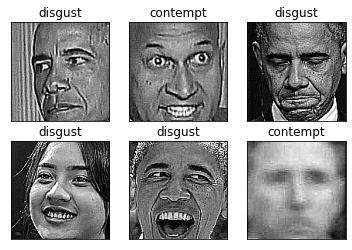

In [23]:
for i in range(len(prediction)):
    plt.subplot(2,3,i+1)
    plt.imshow(clean_result[i], cmap="gray")
    plt.title(f"{prediction[i]}")
    plt.xticks([]),plt.yticks([])

### Since the test set don't have its own label, I can't say that this model able to predict it well 

But as far as I see, perhaps this model have false prediction in the 4 & 5 picture, where they should be happy. This error perhaps happen because the test set have different face angle compared to training set, since the model trained on straight forward face. But I believe this can be solved by fitting new additional dataset to the model.

3. BeeVision's second project is to build a Dog and Cat recognizer using the dataset provided in https://www.kaggle.com/c/dogs-vs-cats/

a) <b>[LO 2, 15 points]</b> Build Visual Vocabulary from the dataset using the Visual Bag of Words algorithm! Explain comprehensively how the algorithms work!

b) <b>[LO 3, 10 points]</b> Use K-NN to predict the object (i.e., dog or cat) and explain the results!

### Bag of Visual Word

Bag of Visual Word as the name itself, it's a bunch of image patches and their feature vectors which are extracted from the image into a bag. Features vector is nothing but a unique pattern that we can find in an image. The best illustration for this concept is just like this.

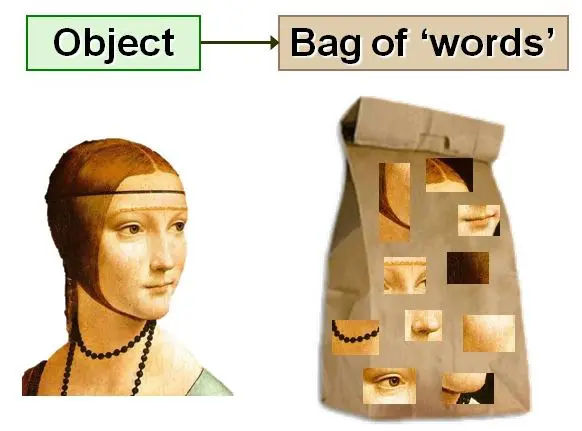

As we can see here, BoVW extracting unique features from face such as nose, eye, etc into a place such as bag. And to extract this unique feature, we can use descriptor of keypoint which is generated by feature extraction algorithm. 

This Image classification using Bag of Visual Words technique contain of three steps:

1. Feature Extraction – Extracting Image features.
2. Codebook Construction – Construction of visual vocabulary by clustering, followed by frequency analysis.
3. Classification – Classification of images based on vocabulary generated using KNN.



### Note*: Please sorry for the inconvenience, because of the limited time and compational resource in calculating this complex data. I need to reduce the given dataset. I'm using low power CPU to compute the given task, and the provided dataset have thousands of image which won't be able to be processed in my laptop, to overcome this I need to decrease the size of the dataset, and take only 500 dataset for dog and cat each, and use 100 data for testing.

<b> I'm still using the same dataset dogs vs cats from Kaggle, and still using the same technique as the instruction told me to. I've tried to train all of the available datasets, but it crashes my computer, and that's why I can't continue it and need to reduce dataset.

### Load Dataset

In [24]:
# initialize value
train_path = "train"
class_names = os.listdir(train_path)

# initialize empty list
image_paths = []

# Prepare train set paths and class
for train_name in class_names:
    
    path = os.path.join(train_path,train_name)
    class_path = [(os.path.join(path,f),train_name) for f in os.listdir(path)]
    image_paths += class_path

<b> The image paths here containing the path and also the classes, now we need to separate it.

In [25]:
image_classes = [classes[1] for classes in image_paths]
image_paths = [path[0] for path in image_paths]

<b> Print the length of each path and class

In [26]:
print(f'Length of Image_Path = {len(image_paths)}')
print(f'Length of Image_Class = {len(image_classes)}')

Length of Image_Path = 1002
Length of Image_Class = 1002


## Now let's extract the feature for each training images using ORB

ORB builds on the well-known FAST keypoint detector and the BRIEF descriptor. So, in order to know about ORB algorithm we should understand what's FAST and BRIEF algorithms works.

### FAST (Features from Accelerated and Segments Test)

1. Given a pixel p in an array, fast will compares the brightness of p to surrounding 16 pixels that are in a small circle around p.

2. Then, the pixels in the circle is sorted into three classes (lighter than p, darker than p or similar to p).

3. If more than 8 pixels are darker or brighter than p than it is selected as a keypoint. So keypoints found by fast gives us information of the location of determining edges in an image.

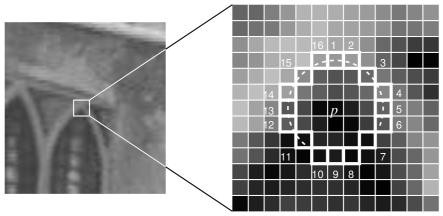

### BRIEF (Binary robust independent elementary feature)

Brief takes all keypoints found by the fast algorithm and convert it into a binary feature vector so that together they can represent an object.

1. Brief start by smoothing image using a Gaussian kernel in order to prevent the descriptor from being sensitive to high-frequency noise.

2. Then, brief select a random pair of pixels in a defined neighborhood around that keypoint. This neighborhood around pixel called as patch, which is a square of some pixel width and height. The first pixel in the random pair is drawn from a Gaussian distribution centered around the keypoint with a standard deviation or spread of sigma. Meanwhile, the second pixel is drawn from Gaussian distribution centered around the first pixel with a standard deviation or spread of sigma by two.

3. If the first pixel is brighter than the second, it assigns the value of 1 to corresponding bit else 0.

4. And brief create this vector for each keypoint in an image.

<b>That's a brief introduction of how the ORB algorithm, the things to be remembered are ORB works by the FAST algorithm as keypoint detector and BRIEF algorithm as the descriptor. Now, let's jump to the code.


In [27]:
# initialize descriptor list
desc_res = []

# Call ORB algorithm
orb=cv2.ORB_create()

# For each image extract the feature using ORB algorithm
for image in image_paths:
    im = cv2.imread(image)
    kp = orb.detect(im,None)
    keypoints,descriptor = orb.compute(im, kp)
    desc_res.append((image, descriptor))

<b> Modify descriptors shape

In [28]:
descriptors = desc_res[0][1]

for image_path,descriptor in desc_res[1:]:
    descriptors = np.vstack((descriptors,descriptor)).astype(float)

descriptors.shape

(452495, 32)

### Codebook Construction - Performing K Means clustering on Descriptors

This is the second step which mentioned before. The vectors generated in the feature extraction step above are now converted into the codewords which is vector representation of similar patches. This codeword also produces a codebook is similar to a word dictionary.

This step will use K-Means algorithm as its cluster techniques, which work by following step:

Given k (number of cluster):

- Select random position of initial centroids.
- Assign each object to the cluster with the nearest centroid.
- Compute each centroid as the mean of the objects assigned to it.
- Repeat steps 2 and 3 until no more change.

And from the cluster above, should be noted that:

1. Each cluster center (centroid) produced by k-means will becomes a codeword.
2. The number of clusters is the codebook size.
3. The codebook is used for quantizing features which means that the Feature vector maps it to the index of the nearest codeword in a codebook.

Here's the illustration of codebook construction

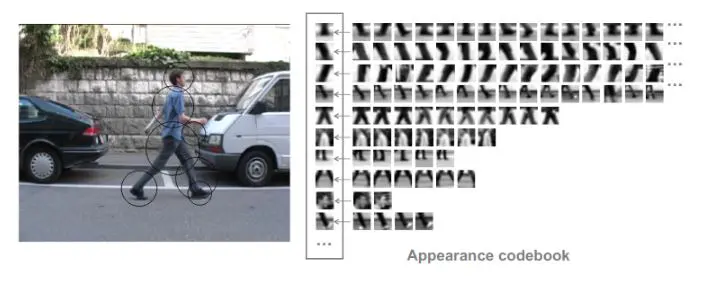

In [29]:
from scipy.cluster.vq import kmeans,vq

# Number of centroids
k = 200

# Call Kmeans Algorithm
voc, variance = kmeans(descriptors,k,1)

### Creating histogram of training image

In [30]:
im_features = np.zeros((len(image_paths),k),"float32")
for i in range(len(image_paths)):
    words,distance = vq(desc_res[i][1],voc)
    for w in words:
        im_features[i][w] += 1

### Apply standardisation / z-score normalization on training feature

In [31]:
from sklearn.preprocessing import StandardScaler
stdslr = StandardScaler().fit(im_features)
im_features = stdslr.transform(im_features)

### Creating Classification Model with KNN

This is the 3rd step which already mentioned before which is build model to classify cat or dogs

In [32]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(im_features,np.array(image_classes))

KNeighborsClassifier()

### The model already trained, now we need to prepare the test set

In [33]:
image_paths_test = [os.path.join('test/test', path) for path in os.listdir('test/test')]

### Compute descriptor for test set which already explained above

In [34]:
des_list_test=[]

for image_pat in image_paths_test:
    image = cv2.imread(image_pat)
    kp = orb.detect(image,None)
    keypoints_test,descriptor_test = orb.compute(image, kp)
    des_list_test.append((image_pat,descriptor_test))

### After long investigation, I found that the test set contain NoneType in the list, which is in index 41, so we need to remove this NoneType to continue the process

In [35]:
del des_list_test[41]

### Creating histogram of testing image

In [36]:
test_features = np.zeros((len(image_paths_test),k),"float32")
for i in range(len(des_list_test)):
        
    words,distance = vq(des_list_test[i][1],voc)
    for w in words:
        test_features[i][w] += 1

### Predict the test set to get the result

Don't forget to normalize the test set

In [37]:
# Standart Scaler
test_features = stdslr.transform(test_features)

# Predict
prediction = clf.predict(test_features)
prediction

array(['dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat',
       'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat',
       'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog',
       'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog',
       'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog',
       'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat',
       'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog',
       'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog',
       'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat',
       'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog',
       'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat',
       'cat'], dtype='<U3')

### The prediction already generated, but since the test set don't have it's own label, we can't calculate the performance matrix. So, to see the result, we need to visualize it.

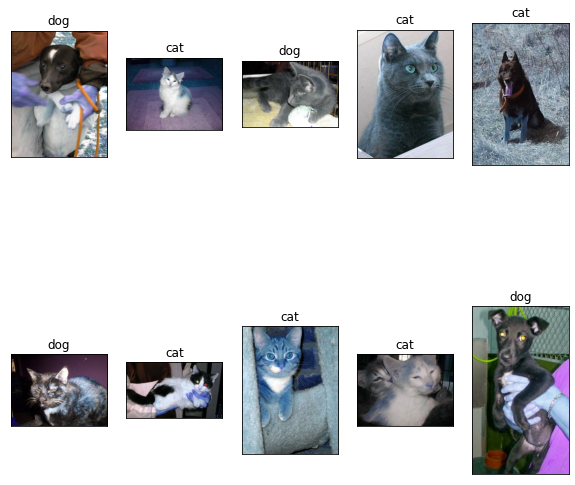

In [38]:
plt.figure(figsize=(10,10))

for i in range(0,10):
    plt.subplot(2,5,i+1)
    plt.imshow(cv2.imread(image_paths_test[i]))
    plt.title(prediction[i])
    plt.xticks([]),plt.yticks([])

### And this is the result of the model, and here's some analysis from my perspective

The model able to classify the test set, but as we can see here, there's some error in the prediction. From the plotted image there's 3 false prediction from the model, but in my humble opinion, I thinks it's not so bad to classify this dog vs cat dataset. 

The reason why there's some error in it, perhaps because the dataset has been reduced. As I mentioned above, the dataset is too huge to be processed in my laptop. 

And the other reason perhaps because the classifier is KNN, KNN known as lazy learner, and actually I'm very doubtful with this algorithm, because in so many paper the performance of KNN always lower than other algorithm such as SVM and others. So, to improve the accuracy of the model perhaps we should change it to the other classifier algorithm

<b> So, as the conclusion, The model able to predict the test set even after reducing the dataset.

4. In addition to building a Dogs Vs Cats recogniser, BeeVision is also planning to develop an instance retrieval system using the same dataset used in no 3 (https://www.kaggle.com/c/dogs-vs-cats/ ). You can also use the Visual Vocabulary created in no 3.

a) <b>[LO 3, 15 points]</b> Your task is to build an instance retrieval system and explain thoroughly how the algorithms work.

b) <b>[LO 3, 5 points]</b> How do you ensure the spatial verification between the correspondence of the images?

c) <b>[LO 3, 5 points]</b> Finally, describe the results!

### Instance Retrieval System

So, Instance Retrieval System itself is the task of searching in a large database for images that match an object in a query image.

So, how this algorithms works? Here's several step that need to be done to create instance retrieval system.

1. Extracting features from each images (use ORB in this case)
2. Cluster the extracted descriptor using Kmeans as Visual Word / Visual Vocabulary (I'm using previous Visual Vocabulary).
3. Find all the closest cluster center / centroid (using Euclidean distance) in the codebook/dictionary.
4. Normalize the histogram by dividing each entry by the sum of all the entries.
5. Compare the new normalized vector using cosine similarity to evaluate how close the query image with images in the database.

And that's the algorithm to create instance retrieval system. Now let's jump to the code.

### Here, we've done doing the 1st and 2nd step in the algorithm. Now, we need to process the 3rd step which is find the closest centroid and each descriptor. 

Since we're using the Visual Vocabulary from 3rd instruction, we can skip the 1st and 2nd step. So, now we need to find the closest centroid to in the codebook, in order to compute it to create instance retrieval system. To do this, we can use euclidean_distance to find the distance each descriptor and centroids. Now, we can use the code below, each code has its own explanation already, so we don't need to discuss about it furthermore.

In [39]:
# define euclediance distance function
def euclidean_distance(a,b):
    distance = np.linalg.norm(a-b)
    return distance

# init empty list as the result
vectors = []

centroids = voc.tolist()

# for each descriptor in each image
for i in range(len(image_paths)):
    count = np.zeros(len(centroids))
    
    # descriptor for each image
    for descriptor in desc_res[i][1]:

        # initialize 0 as closest centroid
        closest_centroid = 0

        # for each index of centroid
        for index in range(len(centroids)):

            # find the distance between the descriptor and indexed centroid / current centroid
            distance = euclidean_distance(descriptor, centroids[index])

            # if the distance less than distance between closest centroid
            if(distance < euclidean_distance(descriptor, centroids[closest_centroid])):

                # swap the current centroid as closest centroid and distance
                closest_centroid = index
            
            count[closest_centroid] += 1

    # after all centroid gained, append to the list
    vectors.append(count)
    
    if i % 100 == 0:
        print(f'Total {i} images has already processed')

Total 0 images has already processed
Total 100 images has already processed
Total 200 images has already processed
Total 300 images has already processed
Total 400 images has already processed
Total 500 images has already processed
Total 600 images has already processed
Total 700 images has already processed
Total 800 images has already processed
Total 900 images has already processed
Total 1000 images has already processed


### This is the 4rd step, where we're asked to normalize the histogram by dividing each entry by the sum of all the entries.

As the instruction is clearly described, let's just jump to the code.

In [40]:
normalized_hist = []

for entries in vectors:
    
    # dividing each entry by the sum of all entries
    normalized = entries/sum(vectors)
    normalized_hist.append(normalized)

# convert list to array
normalized_hist = np.array(normalized_hist)

### Now the last step, we need to compare the new normalized vector using cosine similarity to evaluate how close your query image with images in the database.

So, we need to compare the asked query (normalized vector id) and compare it to all the other vector using cosine similarity, after all distance already computed, we need to find the highest score of cosine similarity and return it as our images.

Input your test picture ID = 1000


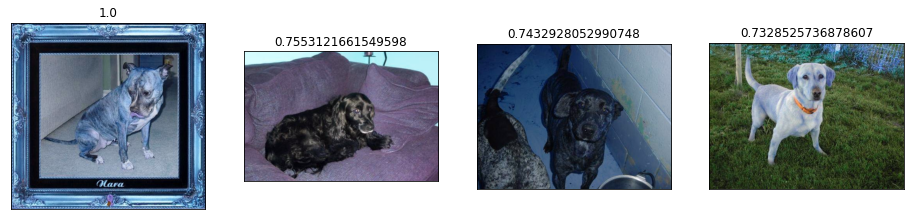

In [41]:
# Find Cosine Similarity
def cosine_similarity(a, b):
    distance = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return distance

# Define which picture ID as query image
query = int(input('Input your test picture ID = '))

# Find cosine similarity for query image and database
distance = []
for i in range(len(image_paths)):
    dist = cosine_similarity(normalized_hist[i],normalized_hist[query])
    distance.append(dist)

# Plot 4 of highest cosine similarity as the result
plt.figure(figsize=(16,16))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(cv2.imread(image_paths[np.flip(np.argsort(distance))[i]]), cmap='gray')
    plt.title(distance[np.flip(np.argsort(distance))[i]])
    plt.xticks([]),plt.yticks([])

 ### How do you ensure the spatial verification between the correspondence of the images?
 
Spatial verification is a technique in which similar locations can be identified in an automated way through a sequence of images. And the general method involves identifying a correlation between certain points among sets images, using techniques similar to those used for image registration. In our case to identify the correlation between certain points, we're using cosine similarity and trying to get its highest number as the similar images.

But the main problem is that outliers affect the adjustment. To overcome this, there's a method that most widely used for spatial verification and avoid errors caused by these outliers which is Random Sample Concensus (RANSAC). But for some reason I didn't apply it in our model, since the result without RANSAC is already able to be used as Instance Retrieval.

### And this is the result of the instance retrieval system 

The result of this instance retrieval system is very good in my opinion. As we can see here in above picture, the user input the picture with ID of 1000 as the query image, which is the 1st left images, and the system will looks for all images in database and return the most similar images. And as we can see here, the result return all in the same class which is dog. So, this is the perfect example of instance retrieval in I think. 

Thanks!!